In [1]:
import os
import random
from tqdm import tqdm
import cv2
from skimage.io import imread,imshow
from skimage.transform import resize
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization
import albumentations as A
from skimage import io
from sklearn.model_selection import train_test_split

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
PATH = "dataset/treecover_segmentation_aerial_goettingen/tiles"
MASK_PATH = "dataset/treecover_segmentation_aerial_goettingen/masks"

In [4]:
train_ids = sorted(next(os.walk(PATH))[2])
mask_train_ids = sorted(next(os.walk(MASK_PATH))[2])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(train_ids,mask_train_ids , 
                                   test_size=0.2, 
                                   shuffle=True)

In [6]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

In [7]:
images = []
for n,id_ in tqdm(enumerate(X_train),total=len(X_train)):
    path=PATH+"/"+id_
    img = plt.imread(path)
    #print(img.shape)
    image_reduced = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
    image = np.array(image_reduced).astype(np.float32)
    #print(image.dtype)
    images.append(image)
images = np.array(images)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.03it/s]


In [8]:
images.shape

(30, 256, 256, 4)

In [9]:
rgb_images = images[:, :, :,0:3]
rgb_images = rgb_images/255.
print(rgb_images.shape)

(30, 256, 256, 3)


In [10]:
masks=[]
for n,id_ in tqdm(enumerate(y_train),total=len(y_train)):
    path=MASK_PATH+"/"+id_
    mask = plt.imread(path)
    mask = np.array(mask).astype(np.float32)
    mask_reduced = cv2.resize(mask, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
    masks.append(mask_reduced)
masks = np.array(masks)

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 159.61it/s]


In [11]:
print("Initial shape is",masks.shape)
masks = np.expand_dims(masks, axis=3)
print("Shape of final mask",masks.shape)

Initial shape is (30, 256, 256)
Shape of final mask (30, 256, 256, 1)


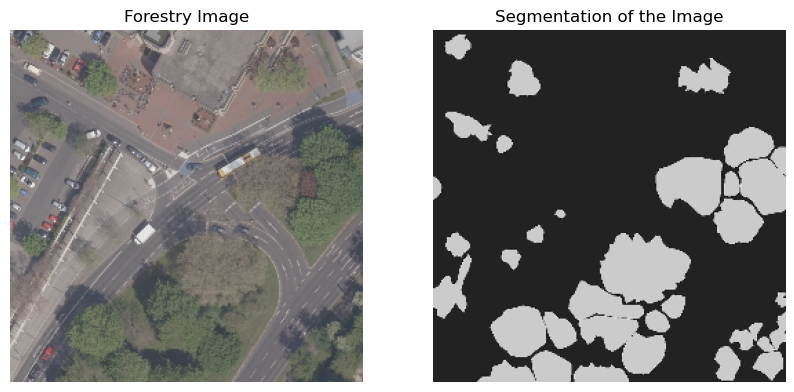

In [12]:
ix=random.randint(0,len(images))
fig = plt.figure(figsize=(10,5))
fig.add_subplot(1,2,1)
plt.axis("off")
plt.title('Forestry Image')
image = rgb_images[ix]
plt.imshow(image)
#plotting image with noise
fig.add_subplot(1,2,2)
plt.axis('off')
plt.title('Segmentation of the Image')
plt.imshow(masks[ix],cmap="gray")
plt.show()

### Data Augmentation

In [13]:
aug = A.Compose([
      A.GaussianBlur(p=0.2,blur_limit=(1,3)), #Blur the input image using a Gaussian filter with a random kernel size.
      A.Sharpen(p=0.4,alpha=(0.1,0.3),lightness=(0.0,0.0)), 
      A.ElasticTransform(p=0.3, alpha=5, sigma=100.0, alpha_affine=20, interpolation=3, border_mode=0, value=(0, 0, 0), mask_value=None, approximate=False, same_dxdy=False),
      A.GridDistortion(p=0.3, num_steps=10, distort_limit=(-0.2, 0.2), interpolation=3, border_mode=0, value=(0, 0, 0), mask_value=None, normalized=False),
      A.Flip(always_apply=False, p=0.3),
      A.OpticalDistortion(p=0.3, distort_limit=(-0.8, 0.8), shift_limit=(-0.1, 0.1), interpolation=0, border_mode=0, value=(0, 0, 0), mask_value=None),
      A.ShiftScaleRotate(p=0.3, shift_limit_x=(-0.2, 0.2), shift_limit_y=(-0.2, 0.2), scale_limit=(-0.2, 0.2), rotate_limit=(-10, 10), interpolation=3, border_mode=2, value=(0, 0, 0), mask_value=None, rotate_method='largest_box'),
      A.ColorJitter(always_apply=False, p=0.3, brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1)),
      A.Downscale(always_apply=False, p=0.3, scale_min=0.75, scale_max=0.85),
      A.GaussNoise(always_apply=False, p=0.3, var_limit=(0.0, 0.001), per_channel=True, mean=0.0),
      A.RGBShift(always_apply=False, p=0.3, r_shift_limit=(-0.1, 0.1), g_shift_limit=(-0.1, 0.1), b_shift_limit=(-0.1, 0.1)),
      A.RandomBrightnessContrast(p=0.3, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=False),
    ]
)

C:\Users\amit\AppData\Roaming\Python\Python39\site-packages\albumentations\augmentations\transforms.py:1554: UserWarning: Using default interpolation INTER_NEAREST, which is sub-optimal.Please specify interpolation mode for downscale and upscale explicitly.For additional information see this PR https://github.com/albumentations-team/albumentations/pull/584
  warnings.warn(


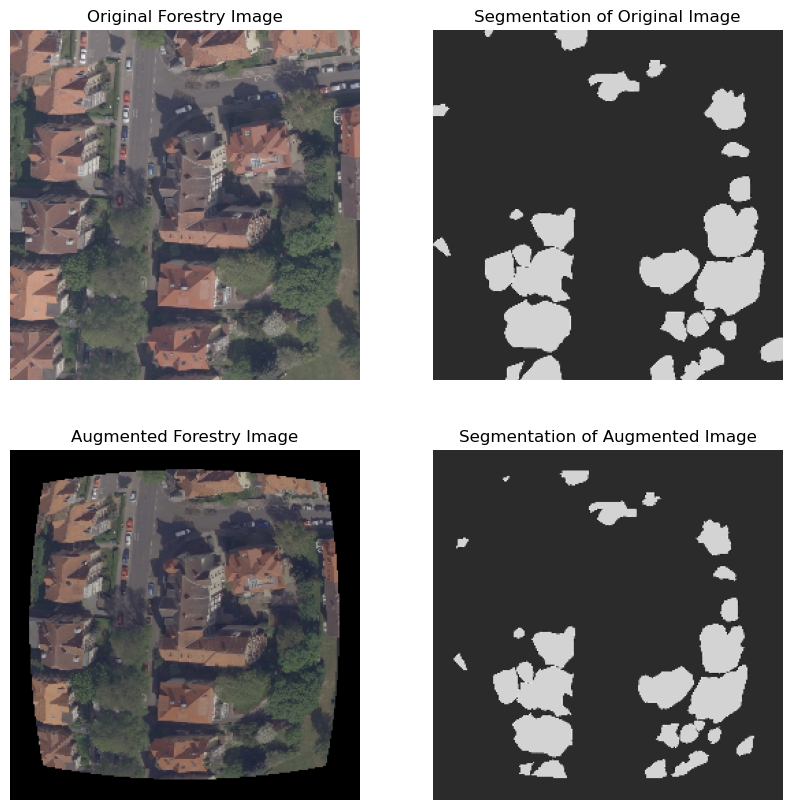

In [14]:
number = random.randint(0,len(X_train)-1)
image = rgb_images[number]
mask = masks[number]
augmented = aug(image = image, mask = mask)
augmented_image = augmented["image"]
augmented_mask = augmented["mask"]
fig = plt.figure(figsize=(10,10))
plt.subplot(221)
plt.axis("off")
plt.title('Original Forestry Image')
original_image = image
plt.imshow(original_image)
plt.subplot(223)
plt.axis("off")
plt.title('Augmented Forestry Image')
image = augmented_image
plt.imshow(image)
#plotting mask
plt.subplot(222)
plt.axis('off')
plt.title('Segmentation of Original Image')
plt.imshow(mask,cmap="gray")
plt.subplot(224)
plt.axis('off')
plt.title('Segmentation of Augmented Image')
plt.imshow(augmented_mask,cmap="gray")
plt.show()


In [15]:
images_to_generate = 200
i = 1
augmented_image = []
augmented_mask = []
while i<=images_to_generate:
    number = random.randint(0,len(X_train)-1)
    image = rgb_images[number]
    mask = masks[number]
    augmented = aug(image = image, mask = mask)
    augmented_image.append(augmented["image"])
    augmented_mask.append(augmented["mask"])
    i=i+1
augmented_image = np.array(augmented_image)
augmented_mask = np.array(augmented_mask)

In [16]:
augmented_image.shape

(200, 256, 256, 3)

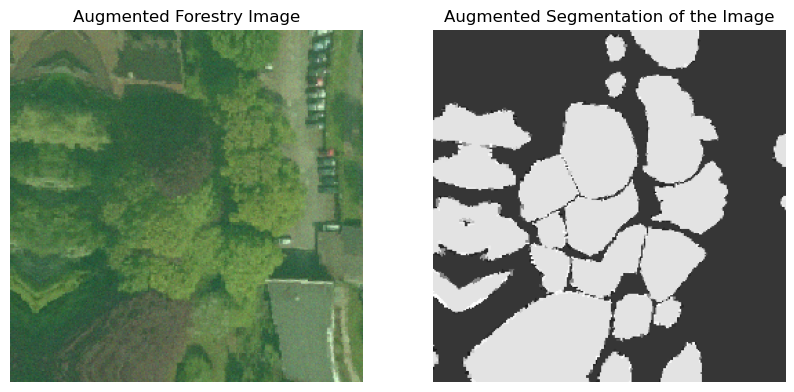

In [17]:
ix=random.randint(0,len(augmented_image))
fig = plt.figure(figsize=(10,5))
fig.add_subplot(1,2,1)
plt.axis("off")
plt.title('Augmented Forestry Image')
image = augmented_image[ix]
plt.imshow(image)
#plotting image with noise
fig.add_subplot(1,2,2)
plt.axis('off')
plt.title('Augmented Segmentation of the Image')
plt.imshow(augmented_mask[ix],cmap="gray")
plt.show()

In [18]:
X = np.concatenate((rgb_images, augmented_image), axis=0)
X.shape

(230, 256, 256, 3)

In [19]:
Y = np.concatenate((masks, augmented_mask), axis=0)
Y.shape

(230, 256, 256, 1)

In [20]:
#https://stackoverflow.com/questions/72195156/correct-implementation-of-dice-loss-in-tensorflow-keras
# def dice_coef(y_true, y_pred, smooth = 100):        
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
#     return dice
def dice_coef(y_true, y_pred, smooth = 1e-5):
    intersection = tf.reduce_sum(tf.multiply(y_true, y_pred), axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    dice_scores_tensor = (2. * intersection + smooth) / (union + smooth)
    mean_dice_score = tf.reduce_mean(dice_scores_tensor)
    return mean_dice_score

In [21]:
def dice_coef_loss_and_bce(y_true, y_pred):
    dice_loss = 1- dice_coef(y_true, y_pred) 
#     y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
#     term_0 = (1 - y_true) * K.log(1 - y_pred + K.epsilon())  
#     term_1 = y_true * K.log(y_pred + K.epsilon())
#     bce_loss = -K.mean(term_0 + term_1)
#     mean = 0.8*(dice_loss) + 0.2*(bce_loss)
    return dice_loss

In [22]:
inputs = tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS),dtype=tf.float32)

### Constructing U NET

In [23]:
#Encoder
c1 = tf.keras.layers.Conv2D(32,(3,3),activation="relu",kernel_initializer = "he_normal",padding="same")(inputs)
c1 = BatchNormalization()(c1)
c1 = tf.keras.layers.Conv2D(32,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c1)
c1 = BatchNormalization()(c1)
p1=tf.keras.layers.MaxPooling2D((2,2))(c1)
p1 = tf.keras.layers.Dropout(0.2)(p1)

In [24]:
c2=tf.keras.layers.Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p1)
c2 = BatchNormalization()(c2)
c2=tf.keras.layers.Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c2)
c2 = BatchNormalization()(c2)
p2= tf.keras.layers.MaxPooling2D((2,2))(c2)
p2 = tf.keras.layers.Dropout(0.3)(p2)

In [25]:
c3=tf.keras.layers.Conv2D(128,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p2)
c3 = BatchNormalization()(c3)
c3=tf.keras.layers.Conv2D(128,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c3)
c3 = BatchNormalization()(c3)
p3=tf.keras.layers.MaxPooling2D((2,2))(c3)
p3=tf.keras.layers.Dropout(0.3)(p3)

In [26]:
c4=tf.keras.layers.Conv2D(256,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p3)
c4 = BatchNormalization()(c4)
c4=tf.keras.layers.Conv2D(256,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c4)
c4 = BatchNormalization()(c4)

In [27]:
#expansive path

In [28]:
u5 = tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding="same")(c4)
u5=tf.keras.layers.concatenate([u5,c3])
u5=tf.keras.layers.Dropout(0.3)(u5)
c5=tf.keras.layers.Conv2D(128,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(u5)
c5 = BatchNormalization()(c5)
c5=tf.keras.layers.Conv2D(128,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c5)
c5 = BatchNormalization()(c5)

In [29]:
u6 = tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding="same")(c5)
u6=tf.keras.layers.concatenate([u6,c2])
u6=tf.keras.layers.Dropout(0.3)(u6)
c6=tf.keras.layers.Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(u6)
c6 = BatchNormalization()(c6)
c6=tf.keras.layers.Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c6)
c6 = BatchNormalization()(c6)

In [30]:
u7 = tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding="same")(c6)
u7=tf.keras.layers.concatenate([u7,c1])
u7=tf.keras.layers.Dropout(0.3)(u7)
c7=tf.keras.layers.Conv2D(32,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(u7)
c7 = BatchNormalization()(c7)
c7=tf.keras.layers.Conv2D(32,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c7)
c7 = BatchNormalization()(c7)

In [31]:
outputs=tf.keras.layers.Conv2D(1,(1,1),activation="sigmoid")(c7)

In [32]:
model_forestry=tf.keras.Model(inputs=[inputs],outputs=[outputs])
model_forestry.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),loss=dice_coef_loss_and_bce,metrics=[dice_coef])
model_forestry.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

 spose)                         )                                                                 
                                                                                                  
 concatenate_1 (Concatenate)    (None, 128, 128, 12  0           ['conv2d_transpose_1[0][0]',     
                                8)                                'batch_normalization_3[0][0]']  
                                                                                                  
 dropout_4 (Dropout)            (None, 128, 128, 12  0           ['concatenate_1[0][0]']          
                                8)                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 128, 128, 64  73792       ['dropout_4[0][0]']              
                                )                                                                 
          

C:\ProgramData\Anaconda3\envs\py39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [33]:
checkpointer= tf.keras.callbacks.ModelCheckpoint("./segmentation_32.h5",verbose=1,save_best_only=True)

In [34]:
callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=10,monitor="val_loss"),
    tf.keras.callbacks.TensorBoard(log_dir="logs"),
    checkpointer
]

In [35]:
 results = model_forestry.fit(X,Y,validation_split=0.2,batch_size=4,epochs=100,callbacks=callbacks)

Epoch 1/100
46/46 [==============================] - ETA: 0s - loss: 0.5846 - dice_coef: 0.4154
Epoch 1: val_loss improved from inf to 0.62323, saving model to .\segmentation_32.h5
46/46 [==============================] - 47s 755ms/step - loss: 0.5846 - dice_coef: 0.4154 - val_loss: 0.6232 - val_dice_coef: 0.3752
Epoch 2/100
46/46 [==============================] - ETA: 0s - loss: 0.4364 - dice_coef: 0.5636
Epoch 2: val_loss did not improve from 0.62323
46/46 [==============================] - 30s 653ms/step - loss: 0.4364 - dice_coef: 0.5636 - val_loss: 0.6249 - val_dice_coef: 0.3728
Epoch 3/100
46/46 [==============================] - ETA: 0s - loss: 0.3850 - dice_coef: 0.6150
Epoch 3: val_loss did not improve from 0.62323
46/46 [==============================] - 30s 653ms/step - loss: 0.3850 - dice_coef: 0.6150 - val_loss: 0.6275 - val_dice_coef: 0.3700
Epoch 4/100
46/46 [==============================] - ETA: 0s - loss: 0.3655 - dice_coef: 0.6345
Epoch 4: val_loss did not improve f

46/46 [==============================] - ETA: 0s - loss: 0.2675 - dice_coef: 0.7325
Epoch 28: val_loss did not improve from 0.41708
46/46 [==============================] - 38s 821ms/step - loss: 0.2675 - dice_coef: 0.7325 - val_loss: 0.4545 - val_dice_coef: 0.5470
Epoch 29/100
46/46 [==============================] - ETA: 0s - loss: 0.2693 - dice_coef: 0.7307
Epoch 29: val_loss did not improve from 0.41708
46/46 [==============================] - 30s 653ms/step - loss: 0.2693 - dice_coef: 0.7307 - val_loss: 0.4377 - val_dice_coef: 0.5658
Epoch 30/100
46/46 [==============================] - ETA: 0s - loss: 0.2634 - dice_coef: 0.7366
Epoch 30: val_loss did not improve from 0.41708
46/46 [==============================] - 30s 658ms/step - loss: 0.2634 - dice_coef: 0.7366 - val_loss: 0.4650 - val_dice_coef: 0.5362
Epoch 31/100
46/46 [==============================] - ETA: 0s - loss: 0.2604 - dice_coef: 0.7396
Epoch 31: val_loss did not improve from 0.41708
46/46 [========================

Epoch 57/100
46/46 [==============================] - ETA: 0s - loss: 0.2082 - dice_coef: 0.7918
Epoch 57: val_loss did not improve from 0.36320
46/46 [==============================] - 35s 771ms/step - loss: 0.2082 - dice_coef: 0.7918 - val_loss: 0.3636 - val_dice_coef: 0.6344
Epoch 58/100
46/46 [==============================] - ETA: 0s - loss: 0.2137 - dice_coef: 0.7863
Epoch 58: val_loss improved from 0.36320 to 0.35104, saving model to .\segmentation_32.h5
46/46 [==============================] - 34s 742ms/step - loss: 0.2137 - dice_coef: 0.7863 - val_loss: 0.3510 - val_dice_coef: 0.6503
Epoch 59/100
46/46 [==============================] - ETA: 0s - loss: 0.2121 - dice_coef: 0.7879
Epoch 59: val_loss did not improve from 0.35104
46/46 [==============================] - 30s 658ms/step - loss: 0.2121 - dice_coef: 0.7879 - val_loss: 0.3718 - val_dice_coef: 0.6274
Epoch 60/100
46/46 [==============================] - ETA: 0s - loss: 0.2033 - dice_coef: 0.7967
Epoch 60: val_loss impro

46/46 [==============================] - ETA: 0s - loss: 0.1708 - dice_coef: 0.8292
Epoch 85: val_loss improved from 0.29498 to 0.29277, saving model to .\segmentation_32.h5
46/46 [==============================] - 32s 698ms/step - loss: 0.1708 - dice_coef: 0.8292 - val_loss: 0.2928 - val_dice_coef: 0.7083
Epoch 86/100
46/46 [==============================] - ETA: 0s - loss: 0.1698 - dice_coef: 0.8302
Epoch 86: val_loss did not improve from 0.29277
46/46 [==============================] - 30s 661ms/step - loss: 0.1698 - dice_coef: 0.8302 - val_loss: 0.2943 - val_dice_coef: 0.7039
Epoch 87/100
46/46 [==============================] - ETA: 0s - loss: 0.1694 - dice_coef: 0.8306
Epoch 87: val_loss did not improve from 0.29277
46/46 [==============================] - 30s 661ms/step - loss: 0.1694 - dice_coef: 0.8306 - val_loss: 0.2932 - val_dice_coef: 0.7052
Epoch 88/100
46/46 [==============================] - ETA: 0s - loss: 0.1717 - dice_coef: 0.8283
Epoch 88: val_loss improved from 0.29

C:\Users\amit\AppData\Local\Temp\ipykernel_7832\3874209565.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, dice_coef, 'b', label='Training dice coefficent',color="green")
C:\Users\amit\AppData\Local\Temp\ipykernel_7832\3874209565.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_dice_coef, 'b', label='Validation dice coefficient',color="blue")
C:\Users\amit\AppData\Local\Temp\ipykernel_7832\3874209565.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', label='Training loss',color="green")
C:\Users\amit\AppData\Local\Temp\ipykernel_7832\3874

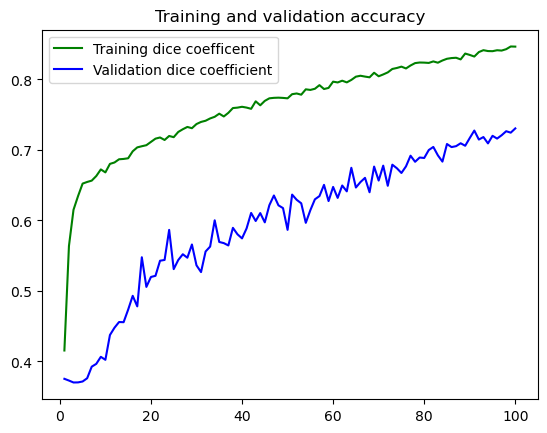

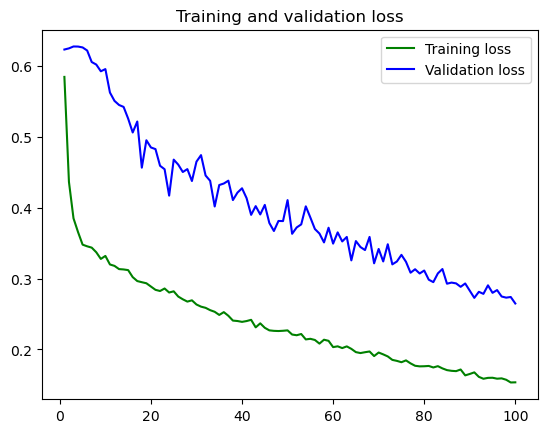

In [37]:
dice_coef = results.history['dice_coef']
val_dice_coef = results.history['val_dice_coef']
loss = results.history['loss']
val_loss = results.history['val_loss']
import matplotlib.pyplot as plt
epochs = range(1, len(dice_coef) + 1)

plt.plot(epochs, dice_coef, 'b', label='Training dice coefficent',color="green")
plt.plot(epochs, val_dice_coef, 'b', label='Validation dice coefficient',color="blue")
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.savefig('vanilla_train_diceloss_bs32.png')
plt.plot(epochs, loss, 'b', label='Training loss',color="green")
plt.plot(epochs, val_loss, 'b', label='Validation loss',color="blue")
plt.title('Training and validation loss')
plt.legend()
plt.savefig('vanilla_loss_diceloss_bs32.png')

plt.show()

### Checking Prediction on Test Data set

In [38]:
test_images = []
for n,id_ in tqdm(enumerate(X_test),total=len(X_test)):
    path=PATH+"/"+id_
    img = plt.imread(path)
    #print(img.shape)
    image_reduced = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
    image = np.array(image_reduced).astype(np.float32)
    #print(image.dtype)
    test_images.append(image)
test_images = np.array(test_images)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 56.33it/s]


In [39]:
rgb_test_images = test_images[:, :, :,0:3]
rgb_test_images = rgb_test_images/255.
print(rgb_test_images.shape)

(8, 256, 256, 3)


In [40]:
test_masks = []
for n,id_ in tqdm(enumerate(y_test),total=len(y_test)):
    path=MASK_PATH+"/"+id_
    mask = plt.imread(path)
    #print(img.shape)
    mask_reduced = cv2.resize(mask, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
    mask = np.array(mask_reduced).astype(np.float32)
    #print(image.dtype)
    test_masks.append(mask)
test_masks = np.array(test_masks)

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 200.00it/s]


In [41]:
print("Initial shape is",test_masks.shape)
test_masks = np.expand_dims(test_masks, axis=3)
print("Shape of final mask",test_masks.shape)

Initial shape is (8, 256, 256)
Shape of final mask (8, 256, 256, 1)


In [42]:
y_pred=model_forestry.predict(rgb_test_images)
y_pred_thresholded = y_pred > 0.5

1/1 [==============================] - 8s 8s/step


In [43]:
intersection = np.logical_and(test_masks, y_pred_thresholded)
union = np.logical_or(test_masks, y_pred_thresholded)
dice_score = (2*np.sum(intersection)) / np.sum(union)
print("Dice score on test dataset is: ", dice_score)

Dice score on test dataset is:  1.2175743573788071


In [59]:
def prediction_on_test_image(input_image):
    img_batch = np.expand_dims(input_image, axis=0)

    #prediction = model_forestry.predict(img_batch)
    prediction = (model_forestry.predict(img_batch)[0,:,:,0] > 0.9).astype(np.uint8)
    prediction = prediction
    return prediction
test_image_number = random.randint(0,len(rgb_test_images))
test_image = rgb_test_images[test_image_number]
prediction = prediction_on_test_image(test_image) 
test_image_mask = test_masks[test_image_number]

1/1 [==============================] - 0s 31ms/step


In [60]:
intersection = np.logical_and(test_image_mask, prediction)
union = np.logical_or(test_image_mask, prediction)
dice_score = (2*np.sum(intersection)) / np.sum(union)
print("Dice score on test dataset is: ", dice_score)

Dice score on test dataset is:  0.1911046963049764


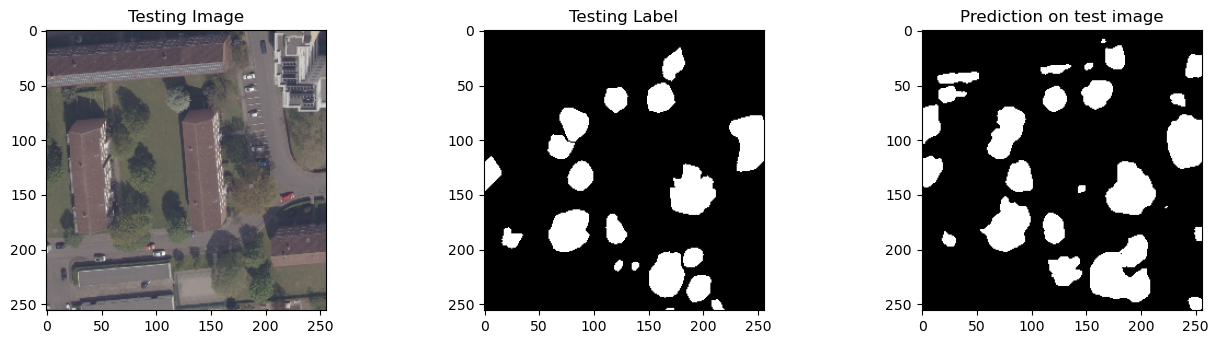

In [61]:
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_image_mask, cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()